In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as smp
from scipy.integrate import odeint
import plotly.graph_objects as go
from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

In [ ]:
t = smp.symbols('t', real=True)
the, phi = smp.symbols(r'\theta \phi', cls=smp.Function)
the = the(t)
phi = phi(t)

# Derivatives
the_d = smp.diff(the,t)
phi_d = smp.diff(phi,t)

# Second derivatives
the_dd = smp.diff(the_d,t)
phi_dd = smp.diff(phi_d,t)

In [ ]:
#definitions
#rotational inertia
Ixx = 0.00012875
Iyy = 0.00012875
Izz = 0.0000075

g = 9.8
m = 0.15
q = 1000
Q = 50
l = 0.1
r = 0.01
h = 0.03

In [ ]:
psi = 0
psi_d = 0
omega = smp.Matrix([phi_d*smp.sin(the)*smp.sin(psi)+the_d*smp.cos(psi),
                    phi_d*smp.sin(the)*smp.cos(psi)-the_d*smp.sin(psi),
                    phi_d*smp.cos(the)+psi_d])
omega


Matrix([
[             Derivative(\theta(t), t)],
[sin(\theta(t))*Derivative(\phi(t), t)],
[cos(\theta(t))*Derivative(\phi(t), t)]])

In [ ]:
I = smp.Matrix([[Ixx,0,0],[0,Iyy,0],[0,0,Izz]])
I

Matrix([
[0.00012875,          0,      0],
[         0, 0.00012875,      0],
[         0,          0, 7.5e-6]])

In [ ]:
#horizontal distance to the center of mass
distance = -r*smp.cos(the) + r + l/2*smp.sin(the)

#position of the center of mass
z = -r*smp.sin(the)-1/2*smp.cos(the)
x = distance*smp.cos(phi)
y = distance*smp.sin(phi)

#velocities of the center of mass
distance_d = smp.diff(distance,t)
x_d = smp.diff(x,t)
y_d = smp.diff(y,t)
z_d = smp.diff(z,t)

In [ ]:
translation = 1/2*m*(x_d**2 + y_d**2 + z_d**2)
rotation = 1/2*omega.T.dot(I*omega).simplify()

distance_to_charge = (r*r*(1-smp.cos(the))**2+(h+r*smp.sin(the))**2)**0.5
V = g*z*smp.cos(the) - q*Q/10**7/distance_to_charge
L = translation + rotation - V




In [ ]:
LE1 = smp.diff(L, the) - smp.diff(smp.diff(L, the_d), t)
LE1 = LE1.simplify()

LE2 = smp.diff(L, phi) - smp.diff(smp.diff(L, phi_d), t)
LE2 = LE2.simplify()

In [ ]:
sols = smp.solve([LE1, LE2], (the_dd, phi_dd),
                simplify=False, rational=False)

In [ ]:
dz1dt_f = smp.lambdify((the, phi, the_d, phi_d), sols[the_dd])
dthedt_f = smp.lambdify(the_d, the_d)

dz2dt_f = smp.lambdify((the, phi, the_d, phi_d), sols[phi_dd])
dphidt_f = smp.lambdify(phi_d, phi_d)

In [ ]:
def dSdt(S, t):
    the, z1, phi, z2 = S
    return [
        dthedt_f(z1),
        dz1dt_f(the,phi,z1,z2),
        dphidt_f(z2),
        dz2dt_f(the,phi,z1,z2),
    ]

In [ ]:
time = 4   #總共運行時間
dt = 0.0001  #數值解的時間間隔
samples = time/dt
t = np.linspace(0, time, int(samples))
ans1 = odeint(dSdt, y0 = [0.5, 0.0, 0, 200.0], t = t)
theta = ans1.T[0]
#phi_d = ans1.T[3]
#plt.plot(t, theta)
#plt.plot(t, phi_d)
#plt.show()

path = r"Numerical Solution.txt"
with open (path,'w') as f:
  f.write(str([r,l,h,dt])+"\n")
  for n in range(0,int(samples)-1):
    distance = -r*smp.cos(the[n]) + r + l/2*smp.sin(the[n])
    x = distance*smp.cos(phi[n])
    y = distance*smp.sin(phi[n])
    z = -r*smp.sin(the[n])-l/2*smp.cos(the[n])
    f.write(str([n*dt,x,y,z,the[n],phi[n],psi[n]])+"\n")
f.close()

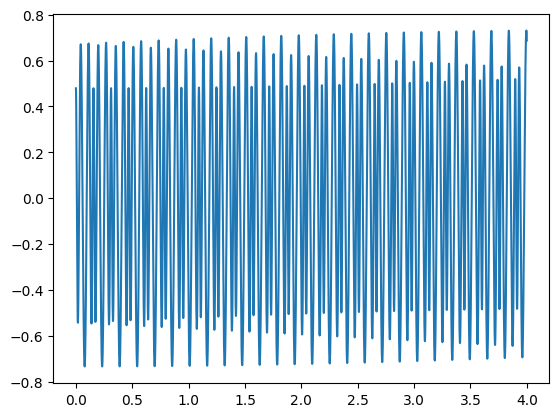

In [ ]:
def get_pos(t, the_t, phi_t):
    return (np.sin(phi_t)*np.sin(the_t),
           np.cos(phi_t)*np.sin(the_t),
           np.cos(the_t))

x, y, z = get_pos(t, ans1.T[0], ans1.T[2])
plt.plot(t,y)

In [ ]:
def animate(i):
    ln1.set_data([0, x[i]], [0, y[i]])

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-6,6)
ax.set_xlim(-6,6)
ani = animation.FuncAnimation(fig, animate, frames=samples-1, interval=1)
ani.save('EulerPendulum.gif',writer='pillow',fps=25)